In [827]:
# Define a multi-armed bandit problem, where the reward distribution of each arm is a Bernoulli distribution.
import numpy as np
import matplotlib.pyplot as plt

class BernoulliBandit:
    def __init__(self, n_arms, means=None):
        self.n_arms = n_arms
        self.means = means
        self.optimal_arm = np.argmax(self.means)
    
    def pull(self, action):
        return np.random.binomial(1, self.means[action])
    
    def optimal_value(self):
        return self.means[self.optimal_arm]

# Define an agent that uses the UCB algorithm to solve the multi-armed bandit problem.
class UCBmixLCB:
    def __init__(self, n_arms, c=2):
        self.n_arms = n_arms
        self.c = c
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        self.t = 0
    
    def ucb_select_arm(self):
        self.t += 1
        ucb_values = self.values + self.c * np.sqrt(1 / (self.counts + 1e-5))
        return np.argmax(ucb_values)

    def lcb_select_arm(self):
        self.t += 1
        lcb_values = self.values #- self.c * np.sqrt(1 / (self.counts + 1e-5))
        # lower bound by 0
        lcb_values = np.maximum(lcb_values, 0)
        # if there are still arms with 0 counts, select them
        if np.any(self.counts == 0):
            return np.argmin(self.counts)
        return np.argmax(lcb_values)
    
    def greedy_select_arm(self):
        # if np.any(self.counts == 0):
        #     return np.argmin(self.counts)
        return np.argmax(self.values)
    
    def update(self, action, reward):
        self.counts[action] += 1
        self.values[action] += (reward - self.values[action]) / self.counts[action]

In [782]:
seed = 0
np.random.seed(seed)
n_arms = 100
means = np.random.rand(n_arms)
# bound the means to [0.1, 0.9]
means = np.maximum(means, 0.1)
means = np.minimum(means, 0.9)
means[50] = 0.95
bandit = BernoulliBandit(n_arms, means)

In [828]:
c = 20

n_iter = 100000
n_experiments = 10
mix_joint_rewards = np.zeros((n_experiments, n_iter))
ucb_joint_rewards = np.zeros((n_experiments, n_iter))
greedy_joint_rewards = np.zeros((n_experiments, n_iter))
opt_weight = 0.5


In [829]:
for _ in range(n_experiments):
    mixagent = UCBmixLCB(n_arms, c)
    ucbagent = UCBmixLCB(n_arms, c)
    greedyagent = UCBmixLCB(n_arms, c)
    for i in range(n_iter):
        # sample a number from the uniform distribution
        p = np.random.uniform(0, 1)
        if p < opt_weight:
            mix_action = mixagent.ucb_select_arm()
        else:
            mix_action = mixagent.lcb_select_arm()
        ucb_action = ucbagent.ucb_select_arm()
        greedy_action = greedyagent.greedy_select_arm()
        mix_reward = bandit.pull(mix_action)
        ucb_reward = bandit.pull(ucb_action)
        greedy_reward = bandit.pull(greedy_action)
        mixagent.update(mix_action, mix_reward)
        ucbagent.update(ucb_action, ucb_reward)
        greedyagent.update(greedy_action, greedy_reward)
        mix_joint_rewards[_, i] = mix_reward
        ucb_joint_rewards[_, i] = ucb_reward
        greedy_joint_rewards[_, i] = greedy_reward

In [830]:
# plot the results of joint_rewards with mean and standard deviation
mix_mean_rewards = np.mean(mix_joint_rewards, axis=0)
mix_std_rewards = np.std(mix_joint_rewards, axis=0)
ucb_mean_rewards = np.mean(ucb_joint_rewards, axis=0)
ucb_std_rewards = np.std(ucb_joint_rewards, axis=0)
greedy_mean_rewards = np.mean(greedy_joint_rewards, axis=0)
greedy_std_rewards = np.std(greedy_joint_rewards, axis=0)
# plt.figure()
# plt.plot(mix_mean_rewards, label='UCBmixLCB')
# plt.fill_between(range(n_iter), mix_mean_rewards - mix_std_rewards, mix_mean_rewards + mix_std_rewards, alpha=0.2)
# plt.plot(ucb_mean_rewards, label='UCB')
# plt.fill_between(range(n_iter), ucb_mean_rewards - ucb_std_rewards, ucb_mean_rewards + ucb_std_rewards, alpha=0.2)
# plt.plot(greedy_mean_rewards, label='Greedy')
# plt.fill_between(range(n_iter), greedy_mean_rewards - greedy_std_rewards, greedy_mean_rewards + greedy_std_rewards, alpha=0.2)
# plt.legend()
# plt.xlabel('Iterations')
# plt.ylabel('Average Reward')
# plt.title('UCBmixLCB vs UCB vs Greedy')
# plt.show()



In [831]:
# plot the cumulative rewards and variance of the three algorithms
mix_cumulative_rewards = np.cumsum(mix_joint_rewards, axis=1)
ucb_cumulative_rewards = np.cumsum(ucb_joint_rewards, axis=1)
greedy_cumulative_rewards = np.cumsum(greedy_joint_rewards, axis=1)

mix_cumulative_rewards_mean = np.mean(mix_cumulative_rewards, axis=0)
mix_cumulative_rewards_std = np.std(mix_cumulative_rewards, axis=0)
ucb_cumulative_rewards_mean = np.mean(ucb_cumulative_rewards, axis=0)
ucb_cumulative_rewards_std = np.std(ucb_cumulative_rewards, axis=0)
greedy_cumulative_rewards_mean = np.mean(greedy_cumulative_rewards, axis=0)
greedy_cumulative_rewards_std = np.std(greedy_cumulative_rewards, axis=0)

In [832]:
# identify the point where mixagent starts to outperform greedyagent
mix_better = 1000
ucb_better = 180000

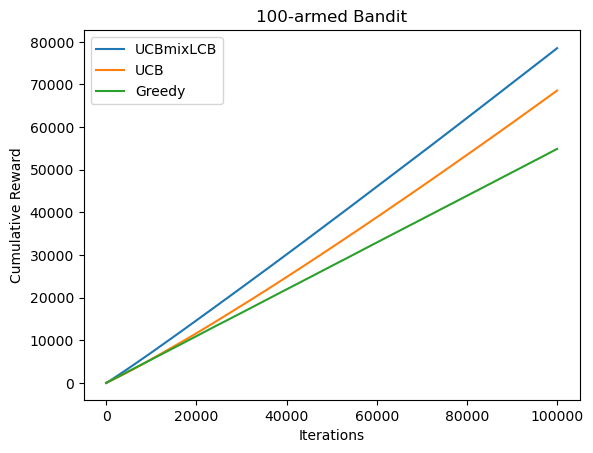

In [833]:
plot_length = 100000
plt.figure()
plt.plot(mix_cumulative_rewards_mean[:plot_length], label='UCBmixLCB')
plt.fill_between(range(plot_length), mix_cumulative_rewards_mean[:plot_length] - mix_cumulative_rewards_std[:plot_length], mix_cumulative_rewards_mean[:plot_length] + mix_cumulative_rewards_std[:plot_length], alpha=0.2)
plt.plot(ucb_cumulative_rewards_mean[:plot_length], label='UCB')
plt.fill_between(range(plot_length), ucb_cumulative_rewards_mean[:plot_length] - ucb_cumulative_rewards_std[:plot_length], ucb_cumulative_rewards_mean[:plot_length] + ucb_cumulative_rewards_std[:plot_length], alpha=0.2)
plt.plot(greedy_cumulative_rewards_mean[:plot_length], label='Greedy')
plt.fill_between(range(plot_length), greedy_cumulative_rewards_mean[:plot_length] - greedy_cumulative_rewards_std[:plot_length], greedy_cumulative_rewards_mean[:plot_length] + greedy_cumulative_rewards_std[:plot_length], alpha=0.2)
# plt.axvline(x=mix_better, color='r', linestyle='--', label='UCBmixLCB outperforms Greedy')
# plt.axvline(x=ucb_better, color='r', linestyle='-.', label='UCB outperforms UCBmixLCB')

# make different color of shaded area for different regions
# plt.fill_between(range(mix_better), 0, 175000, alpha=0.2, color='blue')
# plt.fill_between(range(mix_better, ucb_better), 0, 175000, alpha=0.2, color='green')
# plt.fill_between(range(ucb_better, plot_length), 0, 175000, alpha=0.2, color='red')

plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Cumulative Reward')
plt.title('100-armed Bandit')
plt.show()

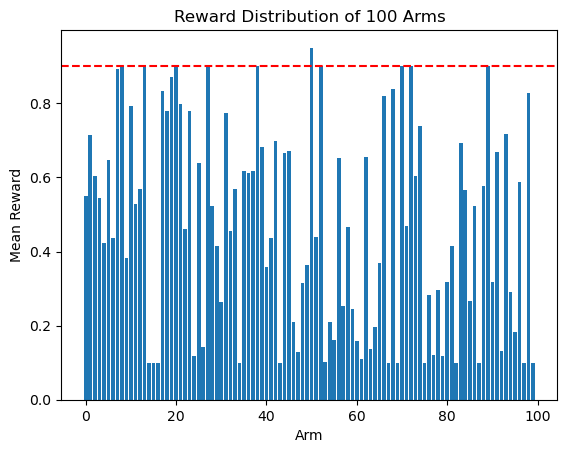

In [793]:
# plot the rewrd distribution of each arm
plt.figure()
plt.bar(range(n_arms), means)
# plot a horizontal line to indicate the optimal value
plt.axhline(y=0.9, color='r', linestyle='--', label='Optimal Value')
plt.xlabel('Arm')
plt.ylabel('Mean Reward')
plt.title('Reward Distribution of 100 Arms')
plt.show()

In [1242]:
# Define a mars-rover environment, where we have 10 states and 2 actions (left and right).
class MarsRover:
    def __init__(self, n_states=10, n_actions=2):
        self.n_states = n_states
        self.n_actions = n_actions
        self.state = 0

    def reset(self):
        self.state = 0
    
    def step(self, action):
        if action == 0:
            self.state = max(0, self.state - 1)
        else:
            self.state = min(self.n_states - 1, self.state + 1)
        if self.state == 0:
            reward = 10
        # if self.state == self.n_states/2:
        #     reward = -250
        else:
            if self.state == self.n_states - 1:
                reward = 250
            else:
                reward = -1
        return self.state, reward

In [1269]:
# Define an agent that uses the UCBmixLCB algorithm to solve the Mars Rover problem.
class UCBmixLCB:
    def __init__(self, n_states, n_actions, horizon, c=2):
        self.n_states = n_states
        self.n_actions = n_actions
        self.H = horizon
        self.c = c
        self.nsa = np.zeros((horizon, n_states, n_actions))
        self.nsas = np.zeros((horizon, n_states, n_actions, n_states))
        self.R = np.zeros((horizon, n_states, n_actions))
        self.Q = np.ones((horizon, n_states, n_actions)) * 10
        self.N = np.zeros((horizon, n_states, n_actions))
        self.t = 0

    def ucb_select_action(self, h, state):
        self.t += 1
        ucb_values = self.Q[h, state] + self.c * np.sqrt(self.t / (self.N[h, state] + 1e-5))
        return np.argmax(ucb_values)
    
    def lcb_select_action(self, h, state):
        lcb_values = self.Q[h, state] #- self.c * np.sqrt(1 / (self.N[h, state] + 1e-5))
        # if there are still actions with 0 counts, select them
        # if np.any(self.N[h, state] == 0):
        #     return np.argmin(self.N[h, state])
        return np.argmax(lcb_values)
    
    def greedy_select_action(self, h, state):
        return np.argmax(self.Q[h, state])
    
    def update(self, h, state, action, reward, next_state):
        self.nsa[h, state, action] += 1
        self.nsas[h, state, action, next_state] += 1
        self.N[h, state, action] += 1
        self.R[h, state, action] += (reward - self.R[h, state, action]) / self.nsa[h, state, action]

    def Q_value_iteration(self):
        # update Q values by value iteration
        for h in range(self.H - 1, -1, -1):
            for state in range(self.n_states):
                for action in range(self.n_actions):
                    if h == self.H - 1:
                        self.Q[h, state, action] = self.R[h, state, action]
                    else:
                        if self.nsa[h, state, action] == 0:
                            continue
                        self.Q[h, state, action] = self.R[h, state, action] + np.sum(self.nsas[h, state, action] / self.nsa[h, state, action] * np.max(self.Q[h + 1], axis=1))

In [1295]:
n_states = 10
n_actions = 2
c = 100
horizon = 9
n_episodes = 10000
n_experiments = 5
mix_joint_rewards = np.zeros((n_experiments, n_episodes))
ucb_joint_rewards = np.zeros((n_experiments, n_episodes))
greedy_joint_rewards = np.zeros((n_experiments, n_episodes))
opt_weight = 0.5

env = MarsRover(n_states, n_actions)
env1 = MarsRover(n_states, n_actions)
env2 = MarsRover(n_states, n_actions)

In [1296]:
# run the experiments

for _ in range(n_experiments):
    mixagent = UCBmixLCB(n_states, n_actions, horizon, c)
    ucbagent = UCBmixLCB(n_states, n_actions, horizon, c)
    greedyagent = UCBmixLCB(n_states, n_actions, horizon, c)
    for episode in range(n_episodes):
        env.reset()
        env1.reset()
        env2.reset()
        p = np.random.uniform(0, 1)
        greedy_history = []
        for h in range(horizon):
            
            state = env.state
            state1 = env1.state
            state2 = env2.state

            if p < opt_weight:
                mix_action = mixagent.ucb_select_action(h, state)
            else:
                mix_action = mixagent.lcb_select_action(h, state)
            ucb_action = ucbagent.ucb_select_action(h, state1)
            greedy_action = greedyagent.greedy_select_action(h, state2)
            next_state, mix_reward = env.step(mix_action)
            next_state1, ucb_reward = env1.step(ucb_action)
            next_state2, greedy_reward = env2.step(greedy_action)
            mixagent.update(h, state, mix_action, mix_reward, next_state)
            ucbagent.update(h, state1, ucb_action, ucb_reward, next_state1)
            greedyagent.update(h, state2, greedy_action, greedy_reward, next_state2)
            mix_joint_rewards[_, episode] += mix_reward
            ucb_joint_rewards[_, episode] += ucb_reward
            greedy_joint_rewards[_, episode] += greedy_reward
            env.state = next_state
            env1.state = next_state1
            env2.state = next_state2
            greedy_history.append((state2, greedy_action, greedy_reward))
        mixagent.Q_value_iteration()
        ucbagent.Q_value_iteration()
        greedyagent.Q_value_iteration()
        if episode == 0:
                print(greedy_history)
                print(greedyagent.Q[0])
        # print("Episode:", episode, "Greedy:", greedy_history)
        # print('Episode:', episode, 'Mix:', mix_joint_rewards[_, episode], 'UCB:', ucb_joint_rewards[_, episode], 'Greedy:', greedy_joint_rewards[_, episode])

[(0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10)]
[[90. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]]
[(0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10)]
[[90. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]]
[(0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10)]
[[90. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]]
[(0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10)]
[[90. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]
 [10. 10.]]
[(0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10), (0, 0, 10)]
[[90. 10.]


In [1297]:
greedy_history

[(0, 0, 10),
 (0, 0, 10),
 (0, 0, 10),
 (0, 0, 10),
 (0, 0, 10),
 (0, 0, 10),
 (0, 0, 10),
 (0, 0, 10),
 (0, 0, 10)]

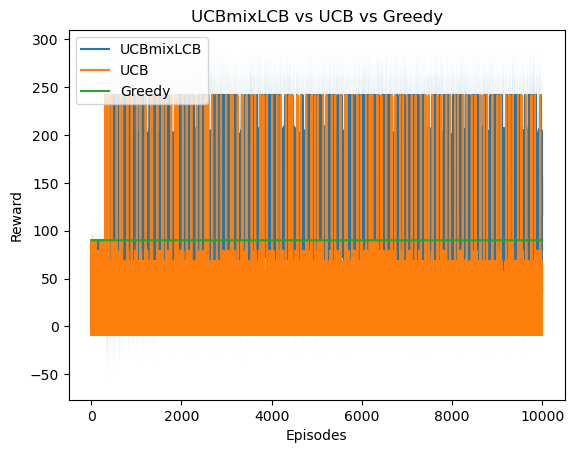

In [1298]:
# plot the results of joint_rewards with mean and standard deviation
mix_mean_rewards = np.mean(mix_joint_rewards, axis=0)
mix_std_rewards = np.std(mix_joint_rewards, axis=0)
ucb_mean_rewards = np.mean(ucb_joint_rewards, axis=0)
ucb_std_rewards = np.std(ucb_joint_rewards, axis=0)
greedy_mean_rewards = np.mean(greedy_joint_rewards, axis=0)
greedy_std_rewards = np.std(greedy_joint_rewards, axis=0)
plt.figure()
plt.plot(mix_mean_rewards, label='UCBmixLCB')
plt.fill_between(range(n_episodes), mix_mean_rewards - mix_std_rewards, mix_mean_rewards + mix_std_rewards, alpha=0.2)
plt.plot(ucb_mean_rewards, label='UCB')
plt.fill_between(range(n_episodes), ucb_mean_rewards - ucb_std_rewards, ucb_mean_rewards + ucb_std_rewards, alpha=0.2)
plt.plot(greedy_mean_rewards, label='Greedy')
plt.fill_between(range(n_episodes), greedy_mean_rewards - greedy_std_rewards, greedy_mean_rewards + greedy_std_rewards, alpha=0.2)
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('UCBmixLCB vs UCB vs Greedy')
plt.show()

In [1299]:
# plot the cumulative rewards and variance of the three algorithms
mix_cumulative_rewards = np.cumsum(mix_joint_rewards, axis=1)
ucb_cumulative_rewards = np.cumsum(ucb_joint_rewards, axis=1)
greedy_cumulative_rewards = np.cumsum(greedy_joint_rewards, axis=1)

mix_cumulative_rewards_mean = np.mean(mix_cumulative_rewards, axis=0)
mix_cumulative_rewards_std = np.std(mix_cumulative_rewards, axis=0)
ucb_cumulative_rewards_mean = np.mean(ucb_cumulative_rewards, axis=0)
ucb_cumulative_rewards_std = np.std(ucb_cumulative_rewards, axis=0)
greedy_cumulative_rewards_mean = np.mean(greedy_cumulative_rewards, axis=0)
greedy_cumulative_rewards_std = np.std(greedy_cumulative_rewards, axis=0)

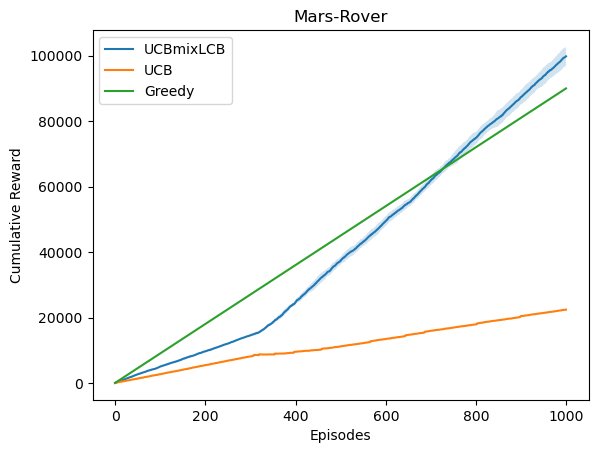

In [1303]:
plot_length = 1000
plt.figure()
plt.plot(mix_cumulative_rewards_mean[:plot_length], label='UCBmixLCB')
plt.fill_between(range(plot_length), mix_cumulative_rewards_mean[:plot_length] - mix_cumulative_rewards_std[:plot_length], mix_cumulative_rewards_mean[:plot_length] + mix_cumulative_rewards_std[:plot_length], alpha=0.2)
plt.plot(ucb_cumulative_rewards_mean[:plot_length], label='UCB')
plt.fill_between(range(plot_length), ucb_cumulative_rewards_mean[:plot_length] - ucb_cumulative_rewards_std[:plot_length], ucb_cumulative_rewards_mean[:plot_length] + ucb_cumulative_rewards_std[:plot_length], alpha=0.2)
plt.plot(greedy_cumulative_rewards_mean[:plot_length], label='Greedy')
plt.fill_between(range(plot_length), greedy_cumulative_rewards_mean[:plot_length] - greedy_cumulative_rewards_std[:plot_length], greedy_cumulative_rewards_mean[:plot_length] + greedy_cumulative_rewards_std[:plot_length], alpha=0.2)
# plt.axvline(x=mix_better, color='r', linestyle='--', label='UCBmixLCB outperforms Greedy')
# plt.axvline(x=ucb_better, color='r', linestyle='-.', label='UCB outperforms UCBmixLCB')

# make different color of shaded area for different regions
# plt.fill_between(range(mix_better), 0, 175000, alpha=0.2, color='blue')
# plt.fill_between(range(mix_better, ucb_better), 0, 175000, alpha=0.2, color='green')
# plt.fill_between(range(ucb_better, plot_length), 0, 175000, alpha=0.2, color='red')

plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Mars-Rover')
plt.show()